<a href="https://colab.research.google.com/github/Akechi1412/Phishing-Website-Detection/blob/main/app/notebooks/training_separated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Train Phishing Webpage Detection Model (separated)**

## **Connect to Drive and Github responsitory**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Github
%cd Phishing-Website-Detection/app
!git config --global user.email 'nguyenphong10042002@gmail.com'
!git config --global user.name 'Akechi1412'
!git fetch origin
!git reset --hard origin/main

/content/drive/MyDrive/Github
/content/drive/MyDrive/Github/Phishing-Website-Detection/app
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 5 (delta 3), reused 0 (delta 0), pack-reused 0 (from 0)
Unpacking objects: 100% (5/5), 91.15 KiB | 60.00 KiB/s, done.
From https://github.com/Akechi1412/Phishing-Website-Detection
   69217f1..4544d8d  main       -> origin/main
Updating files: 100% (73/73), done.
HEAD is now at 4544d8d Created using Colab


## **Load dataset**

In [3]:
import h5py
import tensorflow as tf

In [4]:
def load_url_dataset(file_path, batch_size=1024):
    with h5py.File(file_path, 'r') as f:
        url_data = f['url']
        label_data = f['label']

        num_samples = label_data.shape[0]

        dataset = tf.data.Dataset.from_tensor_slices((
            (
                tf.convert_to_tensor(url_data, dtype=tf.int32),
            ),
            tf.convert_to_tensor(label_data, dtype=tf.int32)
        ))

    dataset = dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

    return dataset

In [5]:
def load_html_dataset(file_path, batch_size=1024):
    with h5py.File(file_path, 'r') as f:
        adjacency_data = f['adjacency']
        feature_data = f['feature']
        label_data = f['label']

        num_samples = label_data.shape[0]

        dataset = tf.data.Dataset.from_tensor_slices((
            (
                tf.convert_to_tensor(adjacency_data, dtype=tf.float32),
                tf.convert_to_tensor(feature_data, dtype=tf.float32)
            ),
            tf.convert_to_tensor(label_data, dtype=tf.int32)
        ))

    dataset = dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

    return dataset

## **Create models functions**

### **Create URL model using Transformer Neutral Network**

In [6]:
!pip install spektral

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.1/140.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 38.7 MB/s eta 0:00:00


In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from utils.layers import PositionalEmbedding, TransformerEncoder

In [8]:
def create_url_model(vocab_size, max_words, embed_dim, num_heads, intermediate_dim,
                     dropout=0.1, num_transformer_layers=1, dense_dim=128, l2_reg=5e-4):
    inputs = keras.Input(shape=(max_words,), dtype=tf.int32)
    x = PositionalEmbedding(max_words, vocab_size, embed_dim)(inputs)
    for _ in range(num_transformer_layers):
        x = TransformerEncoder(embed_dim, num_heads, intermediate_dim)(x)
        x = layers.Dropout(dropout)(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(dense_dim,
                     activation='relu',
                     kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(dense_dim//2,
                     activation='relu',
                     kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    url_model = keras.Model(inputs=inputs, outputs=outputs)

    return url_model

### **Create HTML model using Graph Convolution Network**

In [9]:
from spektral.layers import GCNConv, GlobalSumPool
from utils.layers import GCN

In [10]:
def create_html_model(max_nodes, feature_dim, gcn_units, dropout=0.1,
                      num_gcn_layers=1, dense_dim=128, l2_reg=5e-4):
    inputs_adj = keras.Input(shape=(max_nodes, max_nodes), dtype=tf.float32)
    inputs_feat = keras.Input(shape=(max_nodes, feature_dim), dtype=tf.float32)

    x = inputs_feat
    for _ in range(num_gcn_layers):
        x = GCN(gcn_units, activation='relu')([x, inputs_adj])
        x = layers.Dropout(dropout)(x)
    x = GlobalSumPool()(x)
    x = layers.Dense(dense_dim,
                     activation='relu',
                     kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(dense_dim//2,
                     activation='relu',
                     kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    html_model = keras.Model(inputs=[inputs_adj, inputs_feat], outputs=outputs)

    return html_model

## **Train model**

### **URL Model**

In [11]:
vocab_size = 6000
max_words = 50

url_train_dataset = load_url_dataset('data/train.h5', batch_size=128)
url_val_dataset = load_url_dataset('data/val.h5', batch_size=128)

model = create_url_model(vocab_size=vocab_size,
                          max_words=max_words,
                          dropout=0.1,
                          embed_dim=128,
                          num_heads=8,
                          intermediate_dim=128,
                          num_transformer_layers=2,
                          dense_dim=64,
                          l2_reg=1e-6)

model.summary()

optimizer = keras.optimizers.Adam(learning_rate=1e-3)
metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=metrics)

checkpoint_filepath = 'models/best_url_model.keras'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(url_train_dataset,
                    validation_data=url_val_dataset,
                    epochs=100,
                    callbacks=[checkpoint_callback, early_stopping])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 positional_embedding (Posi  (None, 50, 128)           774400    
 tionalEmbedding)                                                
                                                                 
 transformer_encoder (Trans  (None, 50, 128)           561024    
 formerEncoder)                                                  
                                                                 
 dropout_2 (Dropout)         (None, 50, 128)           0         
                                                                 
 transformer_encoder_1 (Tra  (None, 50, 128)           561024    
 nsformerEncoder)                                                
                                                             

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

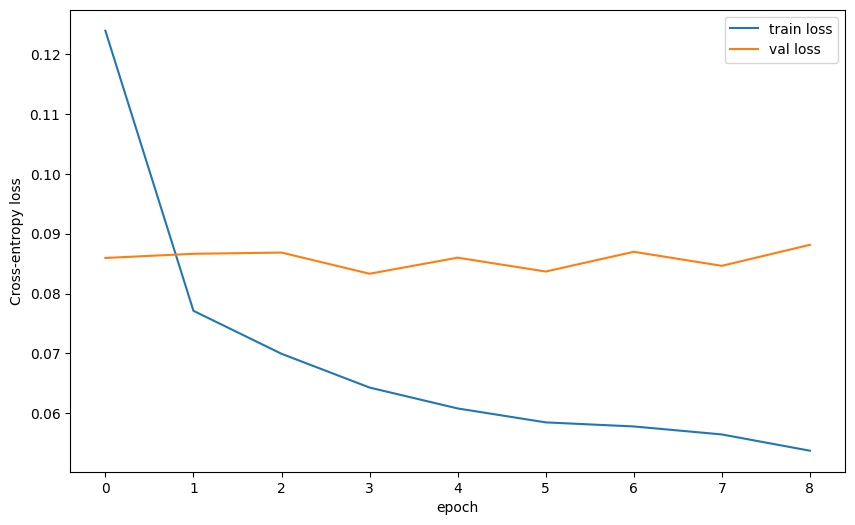

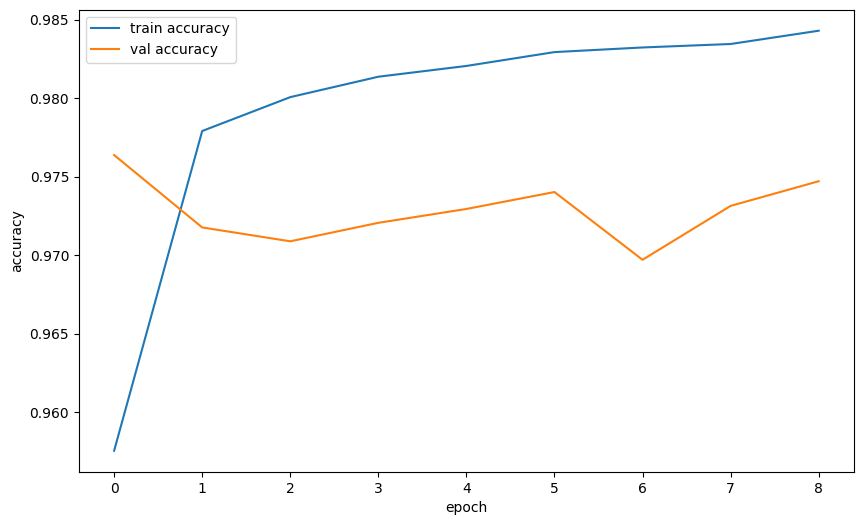

In [13]:
# Plot history loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('epoch')
plt.ylabel('Cross-entropy loss')
plt.legend()
plt.show()

# Plot history accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

### **HTML Model**

In [14]:
max_nodes = 600
feature_dim = 3

html_train_dataset = load_html_dataset('data/train.h5', batch_size=128)
html_val_dataset = load_html_dataset('data/val.h5', batch_size=128)

model = create_html_model(max_nodes=max_nodes,
                          feature_dim=feature_dim,
                          gcn_units=128,
                          num_gcn_layers=2,
                          dropout=0.1,
                          dense_dim=64,
                          l2_reg=1e-6)

model.summary()

optimizer = keras.optimizers.Adam(learning_rate=1e-3)
metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=metrics)

checkpoint_filepath = 'models/best_html_model.keras'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(html_train_dataset,
                    validation_data=html_val_dataset,
                    epochs=100,
                    callbacks=[checkpoint_callback, early_stopping])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 600, 3)]             0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 600, 600)]           0         []                            
                                                                                                  
 gcn (GCN)                   (None, 600, 128)             512       ['input_3[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 dropout_8 (Dropout)         (None, 600, 128)             0         ['gcn[0][0]']           

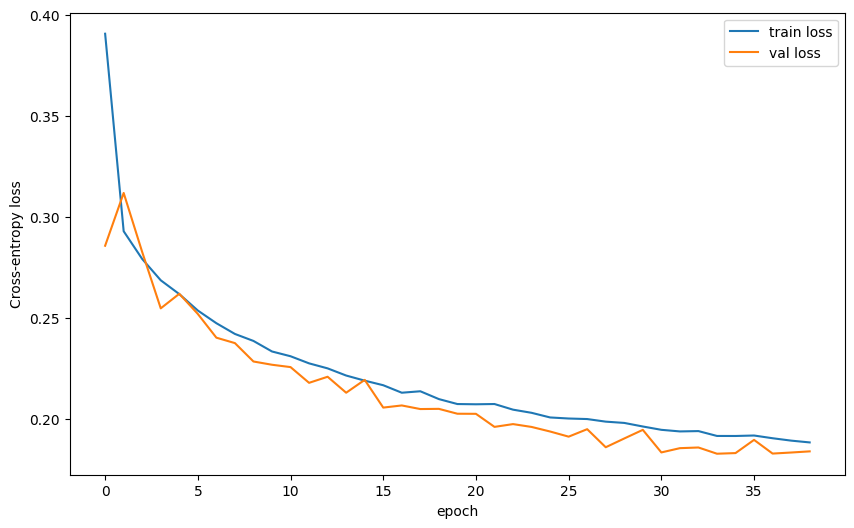

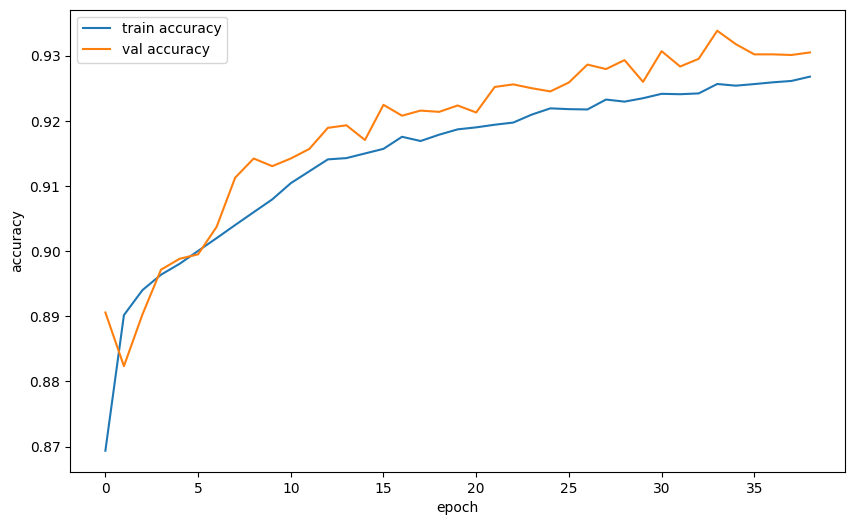

In [15]:
# Plot history loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('epoch')
plt.ylabel('Cross-entropy loss')
plt.legend()
plt.show()

# Plot history accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

## **Evaluate model**

### **URL Model**

In [12]:
best_url_model = keras.models.load_model(
    'models/best_url_model.keras',
    custom_objects={'TransformerEncoder': TransformerEncoder,
                    'PositionalEmbedding': PositionalEmbedding})

In [17]:
best_url_model.save('models/best_url_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [13]:
import numpy as np
from sklearn.metrics import confusion_matrix

In [14]:
url_test_dataset = load_url_dataset('data/test.h5', batch_size=128)

results = best_url_model.evaluate(url_test_dataset, verbose=1)
precision = results[2]
recall = results[3]
f1_score = 2 * (precision * recall) / (precision + recall)
print(f"F1-Score: {f1_score:.4f}")

80/80 [==============================] - 14s 161ms/step - loss: 0.0894 - accuracy: 0.9680 - precision: 0.9639 - recall: 0.9725
F1-Score: 0.9682


80/80 [==============================] - 13s 154ms/step


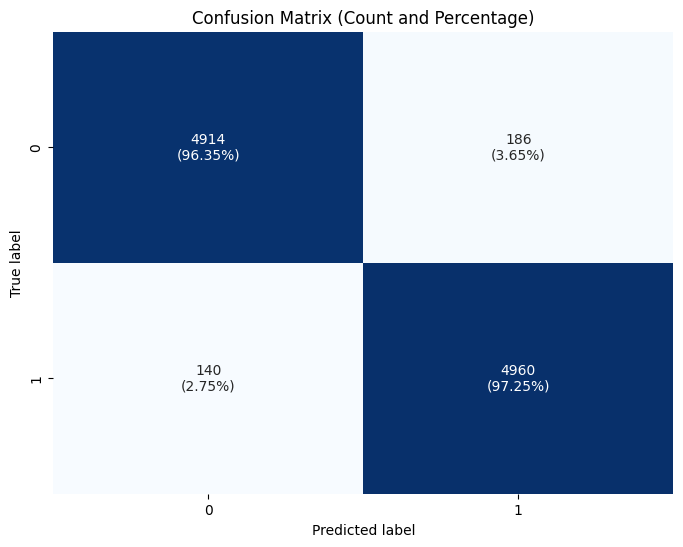

In [15]:
y_pred_prob = best_url_model.predict(url_test_dataset)

y_pred = (y_pred_prob >= 0.5).astype(int)
label_test = tf.concat([y for x, y in url_test_dataset], axis=0).numpy()

cm = confusion_matrix(label_test, y_pred)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

labels = [[f'{int(count)}\n({percentage:.2%})'
           for count, percentage in zip(row_count, row_percentage)]
           for row_count, row_percentage in zip(cm, cm_percentage)]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percentage, annot=labels, fmt='', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (Count and Percentage)')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### **HTML Model**

In [16]:
best_html_model = keras.models.load_model(
    'models/best_html_model.keras',
    custom_objects={'GCNConv': GCNConv,
                    'GlobalSumPool': GlobalSumPool,
                    'GCN': GCN})

In [23]:
best_html_model.save('models/best_html_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:
html_test_dataset = load_html_dataset('data/test.h5', batch_size=128)

results = best_html_model.evaluate(html_test_dataset, verbose=1)
precision = results[2]
recall = results[3]
f1_score = 2 * (precision * recall) / (precision + recall)
print(f"F1-Score: {f1_score:.4f}")

80/80 [==============================] - 24s 168ms/step - loss: 0.1894 - accuracy: 0.9262 - precision_1: 0.9258 - recall_1: 0.9267
F1-Score: 0.9262


80/80 [==============================] - 14s 172ms/step


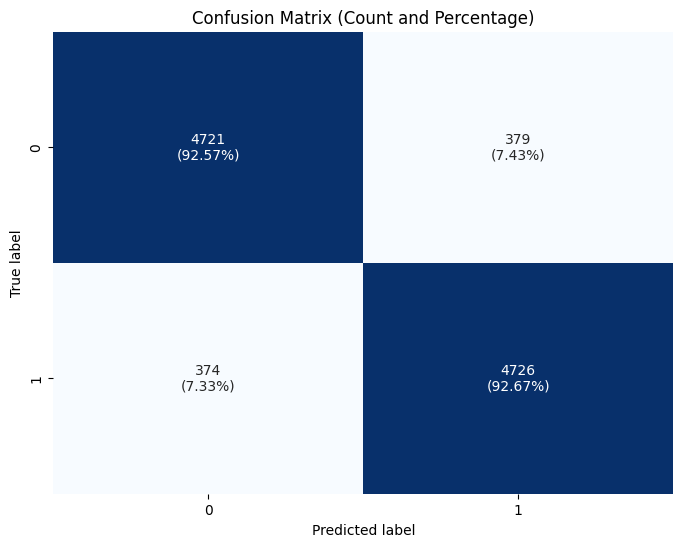

In [18]:
y_pred_prob = best_html_model.predict(html_test_dataset)

y_pred = (y_pred_prob >= 0.5).astype(int)
label_test = tf.concat([y for x, y in html_test_dataset], axis=0).numpy()

cm = confusion_matrix(label_test, y_pred)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

labels = [[f'{int(count)}\n({percentage:.2%})'
           for count, percentage in zip(row_count, row_percentage)]
           for row_count, row_percentage in zip(cm, cm_percentage)]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percentage, annot=labels, fmt='', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (Count and Percentage)')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()